In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
import os
import json
import gspread
from google.oauth2.service_account import Credentials


In [2]:

# ============================================================
# 1️⃣ AUTHENTIFICATION GOOGLE SERVICE ACCOUNT
# ============================================================
SERVICE_ACCOUNT_FILE = "predis-475413-8fe8b46b86fc.json"

if os.path.exists(SERVICE_ACCOUNT_FILE):
    print("✅ Utilisation du fichier JSON local pour l'auth Google")
    creds = Credentials.from_service_account_file(
        SERVICE_ACCOUNT_FILE,
        scopes=["https://www.googleapis.com/auth/spreadsheets",
                "https://www.googleapis.com/auth/drive"]
    )
else:
    print("⚡ Fichier JSON local non trouvé, utilisation du secret GitHub")
    # Le secret GitHub doit contenir le JSON complet du service account
    sa_info_json = os.environ["GOOGLE_SERVICE_ACCOUNT_JSON"]
    sa_info = json.loads(sa_info_json)
    creds = Credentials.from_service_account_info(
        sa_info,
        scopes=["https://www.googleapis.com/auth/spreadsheets",
                "https://www.googleapis.com/auth/drive"]
    )

gc = gspread.authorize(creds)

# ============================================================
# 2️⃣ OUVRIR LE GOOGLE SHEET
# ============================================================
sheet_url = "https://docs.google.com/spreadsheets/d/1PdnadzZswADLqGBrI53a_8IsegivCMSz1pCZOh384-Y/edit?gid=1517184233#gid=1517184233"
spreadsheet = gc.open_by_url(sheet_url)
worksheet = spreadsheet.get_worksheet(0)

# ============================================================
# 3️⃣ CHARGEMENT ET PRÉTRAITEMENT DES DONNÉES
# ============================================================
data = worksheet.get_all_values()

header = data[0]
for i, h in enumerate(header):
    if h == "" or header.count(h) > 1:
        header[i] = f"col_{i+1}"

df_fe = pd.DataFrame(data[1:], columns=header)

for col in df_fe.columns:
    df_fe[col] = pd.to_numeric(df_fe[col], errors="ignore")

df_fe = df_fe.drop(columns=['Est. Win'], errors='ignore')
df_fe["R"] = df_fe["R"].replace(0, np.nan)
df_fe = df_fe.dropna(subset=['R']).head(60)

print("✅ Données importées depuis le Google Sheet :", df_fe.shape)

# ============================================================
# 4️⃣ CONSTRUCTION DES LAGS
# ============================================================
cols_needed = ["Team Gap Early", "R", "Perf intrinsèque"]
WINDOW = 7

for lag in range(1, WINDOW + 1):
    for col in cols_needed:
        df_fe[f"{col}_lag{lag}"] = df_fe[col].shift(lag)

df_fe = df_fe.fillna(0)
df_fe["LoseStreak"] = (df_fe["Team Gap Early"].astype(float) < 0).astype(int)
df_fe["LoseStreak"] = df_fe["LoseStreak"].rolling(3, min_periods=1).sum()

# ============================================================
# 5️⃣ PRÉPARATION POUR LSTM
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(42)
torch.manual_seed(42)

lag_prefixes = ["Team Gap Early", "R", "Perf intrinsèque"]
lag_cols = [f"{p}_lag{i}" for p in lag_prefixes for i in range(1, WINDOW+1)]
agg_keep = ["LoseStreak"]
feature_columns_final = lag_cols + agg_keep

X_df_new = df_fe[feature_columns_final].fillna(0).copy()
y = df_fe["Team Gap Early"].astype(float).values

n = len(X_df_new)
n_train = max(1, int(0.8 * n))
X_train = X_df_new.iloc[:n_train].values
y_train = y[:n_train]

scaler = StandardScaler()
idxs_scale = [i for i, c in enumerate(feature_columns_final)
              if "Team Gap Early" in c or "Perf intrinsèque" in c]
scaler.fit(X_train[:, idxs_scale])
X_train[:, idxs_scale] = scaler.transform(X_train[:, idxs_scale])

def make_seq(X_flat, cols, core_order, agg_keep, window=7):
    n_samples = X_flat.shape[0]
    seqs = np.zeros((n_samples, window, len(core_order) + len(agg_keep)))
    for i in range(n_samples):
        for lag in range(1, window + 1):
            for j, c in enumerate(core_order):
                seqs[i, lag-1, j] = X_flat[i, cols.index(f"{c}_lag{lag}")]
        for a_idx, a in enumerate(agg_keep):
            seqs[i, :, len(core_order)+a_idx] = X_flat[i, cols.index(a)]
    return seqs

core_order = ["Team Gap Early", "R", "Perf intrinsèque"]
X_train_seq = make_seq(X_train, feature_columns_final, core_order, agg_keep, WINDOW)

# ============================================================
# 6️⃣ DÉFINITION DU MODÈLE LSTM
# ============================================================
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = SeqDataset(X_train_seq, y_train)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

class LSTMRegSimple(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze(1)

model = LSTMRegSimple(input_size=X_train_seq.shape[2]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

for epoch in range(50):
    model.train()
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        optimizer.step()

# ============================================================
# 🔮 PRÉDICTIONS POUR LES 2 PROCHAINES GAMES
# ============================================================

def predict_next_n_games(model, df, n_future=2):
    preds_future = []
    last_df = df.copy()

    for _ in range(n_future):
        # Récupérer les dernières lignes nécessaires pour les lags
        last_window = last_df.iloc[-WINDOW:].copy()

        # Construire la ligne suivante
        next_row = {col: 0 for col in last_df.columns}

        # Ajouter les lags récents
        for col in ["Team Gap Early", "R", "Perf intrinsèque"]:
            for lag in range(1, WINDOW + 1):
                lag_col = f"{col}_lag{lag}"
                if lag_col in last_df.columns:
                    next_row[lag_col] = last_window[col].iloc[-lag]

        # LoseStreak : somme des 3 derniers Team Gap Early négatifs
        lose_streak_val = (last_window["Team Gap Early"].astype(float) < 0).astype(int).sum()
        next_row["LoseStreak"] = lose_streak_val

        # Construire DataFrame pour la séquence
        next_df = pd.DataFrame([next_row])
        X_next = next_df[feature_columns_final].fillna(0).values
        X_next_seq = make_seq(X_next, feature_columns_final, core_order, agg_keep, WINDOW)

        # Prédiction
        model.eval()
        with torch.no_grad():
            pred_next = model(torch.tensor(X_next_seq, dtype=torch.float32).to(device)).cpu().numpy()[0]
            pred_next_scaled = 20 + 60 * (1 / (1 + np.exp(-pred_next)))

        preds_future.append(pred_next_scaled)

        # Ajouter la nouvelle ligne avec la prédiction dans le DataFrame
        next_row["Pred_TeamGapEarly"] = pred_next_scaled
        next_row["Team Gap Early"] = pred_next_scaled  # pour simuler la continuité
        last_df = pd.concat([last_df, pd.DataFrame([next_row])], ignore_index=True)

    return preds_future, last_df


# Appeler la fonction
preds_future, df_fe_extended = predict_next_n_games(model, df_fe, n_future=2)

# Afficher les prédictions
for i, p in enumerate(preds_future, 1):
    print(f"🎯 Prédiction game +{i}: {p:.2f}")

# ============================================================
# 🧾 ÉCRITURE DES PRÉDICTIONS DANS LA COLONNE D
# ============================================================
values = [[float(v)] for v in preds_future]  # <-- convert float32 en float

# ligne de départ = fin du tableau
start_row = len(df_fe) + 2
col_letter = "D"
col_name = "Pred_TeamGapEarly_Next"

# écrire l'entête
worksheet.update(values=[[col_name]], range_name=f"{col_letter}1")

# écrire les valeurs en batch
worksheet.update(
    values=values,
    range_name=f"{col_letter}{start_row}:{col_letter}{start_row + len(values) - 1}"
)

print(f"✅ {len(preds_future)} prédictions écrites dans la colonne '{col_name}' ({col_letter}) à partir de la ligne {start_row} !")


✅ Utilisation du fichier JSON local pour l'auth Google
✅ Données importées depuis le Google Sheet : (57, 9)
🎯 Prédiction game +1: 29.06
🎯 Prédiction game +2: 28.93
✅ 2 prédictions écrites dans la colonne 'Pred_TeamGapEarly_Next' (D) à partir de la ligne 59 !


### Bonus matrice de corrélation

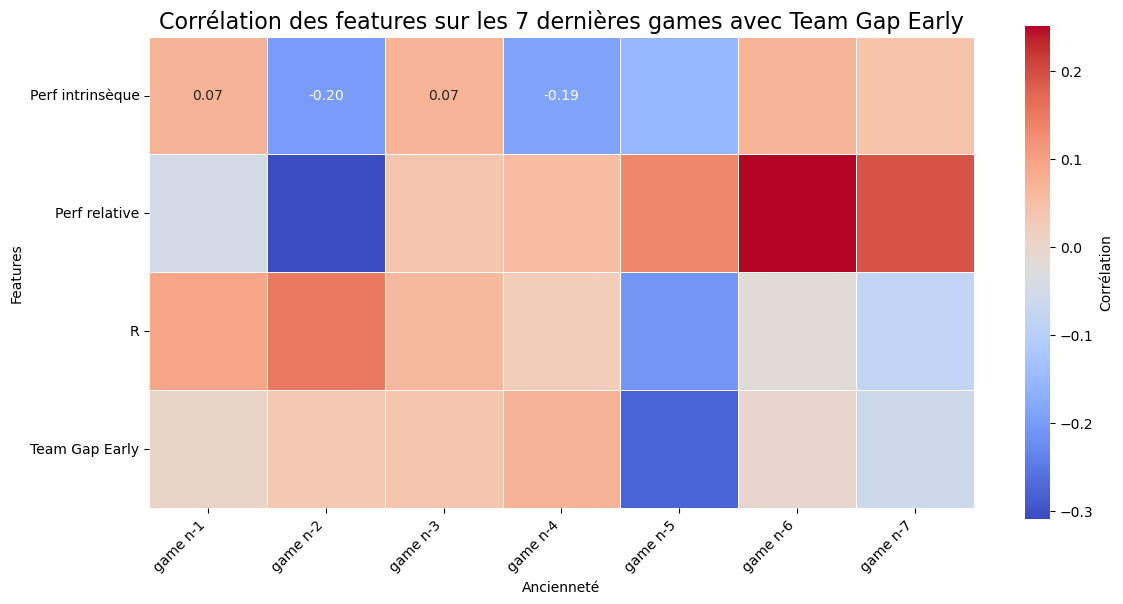

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features = ['R', 'Perf relative', 'Perf intrinsèque', 'Team Gap Early']
target = 'Team Gap Early'
max_lag = 7

df_lagged = df_fe.copy()

# Créer les colonnes lag
for feat in features:
    for lag in range(1, max_lag + 1):
        df_lagged[f'{feat}_lag{lag}'] = df_lagged[feat].shift(lag)

# Supprimer les lignes avec target NaN
df_corr = df_lagged.dropna(subset=[target])

# Calcul des corrélations
corr_dict = {}
for feat in features:
    for lag in range(1, max_lag + 1):
        corr_dict[f'{feat}_lag{lag}'] = df_corr[target].corr(df_corr[f'{feat}_lag{lag}'])

corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['Correlation'])
corr_df['Feature'] = [name.split('_lag')[0] for name in corr_df.index]
corr_df['Lag'] = [int(name.split('_lag')[1]) for name in corr_df.index]

# Pivot pour heatmap
heatmap_data = corr_df.pivot(index='Feature', columns='Lag', values='Correlation')

# Heatmap avec labels
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Corrélation'},
    linewidths=0.5,
    square=True
)

# Forcer les labels pour toutes les cases
ax.set_xticklabels([f"game n-{i}" for i in heatmap_data.columns], rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=10)

plt.title('Corrélation des features sur les 7 dernières games avec Team Gap Early', fontsize=16)
plt.xlabel('Ancienneté')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
